Preprocesamiento

In [ ]:
#class_names = ['PNEUMONIA', 'NORMAL']  # Cambia los nombres de clase según tu caso

# Crear las carpetas de validación si no existen
#for class_name in class_names:
#    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Mover 250 imágenes de cada clase
#for class_name in class_names:
    # Obtener la lista de imágenes en la clase de entrenamiento
#    class_train_dir = os.path.join(train_dir, class_name)
#    images = os.listdir(class_train_dir)

    # Elegir 250 imágenes al azar
#    images_to_move = random.sample(images, 250)

#    for image in images_to_move:
#        # Mover la imagen a la carpeta de validación
#        shutil.move(os.path.join(class_train_dir, image), os.path.join(val_dir, class_name, image))

#print("Imágenes movidas a la carpeta de validación.")

Imágenes movidas a la carpeta de validación.


## 1. Instalaciones necesarias

In [ ]:
import os, sys
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import pydicom
import time
import cv2
import keras
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip,RandomContrast,RandomBrightness, UpSampling2D,add, Input, Conv2D, Activation, Flatten, RandomRotation, RandomZoom, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import BinaryIoU
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
random.seed(42)
from sklearn.metrics import classification_report


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_dir = '/content/drive/MyDrive/0tfm/Kermany/'
dir_mod_RSNA = '/content/drive/MyDrive/0tfm/RSNA/'

train_dir = main_dir + "train"
val_dir  = main_dir + "val"
test_dir = main_dir + "test"
import shutil

In [ ]:
image_size = 224  # Tamaño recomendado para MobileNet
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Escalar los píxeles a [0, 1]
    rotation_range=20,          # Rotar imágenes aleatoriamente
    width_shift_range=0.2,      # Desplazar imágenes horizontalmente
    height_shift_range=0.2,     # Desplazar imágenes verticalmente
    shear_range=0.2,            # Transformación en corte
    zoom_range=0.2,             # Hacer zoom aleatoriamente
    horizontal_flip=True,       # Voltear horizontalmente (puede ser útil)
    fill_mode='nearest'         # Método de relleno
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

# Generador para el set de entrenamiento (con data augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),  # Redimensionar a 224x224 para MobileNet
    batch_size=batch_size,
    class_mode='binary',                   # Clasificación binaria (neumonía o normal)
    color_mode='rgb'                       # Asegurarse de que las imágenes son RGB
)

# Generador para el set de validación
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),  # Redimensionar a 224x224 para MobileNet
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Generador para el set de prueba
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),  # Redimensionar a 224x224 para MobileNet
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False                          # No mezclar el set de prueba
)

Found 4716 images belonging to 2 classes.
Found 515 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Visualizar las curvas de aprendizaje (loss y métricas)

In [ ]:
def plot_learning_curves(history, type_g=1):
    # Graficar la pérdida (loss)
    plt.figure(figsize=(12, 4))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()


    # Métricas para la salida de target binario
    plt.subplot(1, 3, 2)
    if type_g == 1:
      plt.plot(history['accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_accuracy'], label='Accuracy de validación')
    elif type_g == 2:
      plt.plot(history['target_output_accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_target_output_accuracy'], label='Accuracy de validación')
    plt.title('Accuracy del target binario')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    plt.subplot(1, 3, 3)
    if type_g == 1:
      plt.plot(history.iloc[:,4], label='Accuracy de entrenamiento')
      plt.plot(history.iloc[:,9], label='Accuracy de validación')
      plt.title('Recall del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('recall')
      plt.legend()
      plt.ylim(0, 1)
    elif type_g == 2:
      plt.plot(history.iloc[:,1], label='IoU de entrenamiento')
      plt.plot(history.iloc[:,7], label='IoU de validación')
      plt.title('IoU del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('IoU')
      plt.legend()
      plt.ylim(0, 1)

    plt.show()


In [ ]:
# Función para extraer métricas de la última época
def extract_last_epoch_metrics(history_df):
    last_epoch = history_df.iloc[-1]
    return {
        'Loss': last_epoch.iloc[7],          # Cambia el índice si es necesario
        'Accuracy': last_epoch.iloc[5],      # Cambia el índice si es necesario
        'Precision': last_epoch.iloc[8],     # Cambia el índice si es necesario
        'Recall': last_epoch.iloc[9],        # Cambia el índice si es necesario
        'AUC': last_epoch.iloc[6]            # Cambia el índice si es necesario
    }

def comparar_modelos(lista_history_files):

    # Lista de archivos de historial
    lista_history_files = lista_history_files
    lista_metrics = []

    # Extraer métricas para cada modelo
    for item in lista_history_files:
        history_df = pd.read_csv(main_dir + "model_training/" + item)
        metrics = extract_last_epoch_metrics(history_df)
        metrics['Model'] = item  # Añadir el nombre del modelo a las métricas
        lista_metrics.append(metrics)

    # Crear un DataFrame a partir de las métricas
    metrics_df = pd.DataFrame(lista_metrics)

    # Mostrar el DataFrame con las métricas
    print(metrics_df)

## Training the Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,  # Número de epochs sin mejora antes de detener el entrenamiento
                               restore_best_weights=True)  # Para restaurar los pesos del modelo con la mejor pérdida
# Definir ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,     # Reducir el learning rate en un 20%
                              patience=2,     # Esperar 3 épocas sin mejora
                              min_lr=1e-6)    # No reducir el learning rate por debajo de 1e-6

In [ ]:
def train_model(model,
                train_generator,
                val_generator,
                epochs,
                learning_rate,
                model_name,
                callbacks=None
                ):
    """
    Compila y entrena un modelo.

    Args:
        model: El modelo a entrenar.
        train_generator: Generador de datos de entrenamiento.
        val_generator: Generador de datos de validación.
        epochs (int): Número de épocas para el entrenamiento. (default: 1)
        learning_rate (float): Tasa de aprendizaje para el optimizador. (default: 0.001)
        callbacks (list): Lista de callbacks para el entrenamiento. (default: None)
        save_dir (str): Directorio donde se guardará el modelo. (default: "model_training/")
        model_name (str): Nombre del archivo del modelo guardado. (default: 'model')

    """

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ])

    # Entrenamiento del modelo
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=callbacks)

    # Guardar el modelo entrenado
    model.save(main_dir + "model_training/model_" + model_name +".keras")

    # Guardar historial de entrenamiento
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(main_dir + "model_training/history_" + model_name + ".csv", index=False)



In [ ]:
def create_backbone_classification_model_v2(backbone='MobileNetV2'):
    # Entrada
    inputs = Input(shape=(224, 224, 3))

    # Crear el modelo backbone según el backbone seleccionado
    if backbone == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
    elif backbone == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    else:
        raise ValueError(f"Backbone {backbone} no está soportado.")

    # Congelar las capas del backbone
    for layer in base_model.layers:
        layer.trainable = False

    # Conectar el backbone con la salida del modelo
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Aplanar la salida

    # Capas densas para la clasificación
    x = Dense(64, activation='relu')(x)  # Otra capa densa
    target_output = Dense(1, activation='sigmoid')(x)  # Salida para clasificación binaria

    # Crear el modelo
    model = Model(inputs=inputs, outputs=target_output)

    return model


### Mobilnet con batchsize 32

In [ ]:
model = create_backbone_classification_model_v2(backbone='MobileNetV2')
#model.summary()

<ipython-input-43-4ae55cf91bde>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
train_model(model,
            train_generator, val_generator, 10, 0.001, "01_00_mobilnet", [early_stopping, reduce_lr])

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 970s 12s/step - accuracy: 0.8304 - auroc: 0.8169 - loss: 0.4257 - precision_7: 0.8675 - recall_7: 0.9049 - val_accuracy: 0.9398 - val_auroc: 0.9828 - val_loss: 0.1754 - val_precision_7: 0.9558 - val_recall_7: 0.9225 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9314 - auroc: 0.9788 - loss: 0.1576 - precision_7: 0.9586 - recall_7: 0.9523 - val_accuracy: 0.9456 - val_auroc: 0.9834 - val_loss: 0.1608 - val_precision_7: 0.9563 - val_recall_7: 0.9341 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9459 - auroc: 0.9840 - loss: 0.1372 - precision_7: 0.9689 - recall_7: 0.9604 - val_accuracy: 0.8990 - val_auroc: 0.9883 - val_loss: 0.2297 - val_precision_7: 0.9952 - val_recall_7: 0.8023 - learning_rate: 0.0010
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9401 - auroc: 0.9840 - loss: 0.1399 - precision_7: 0.9652 - recall_7: 0.9560 - val_accuracy: 0.9476 - v

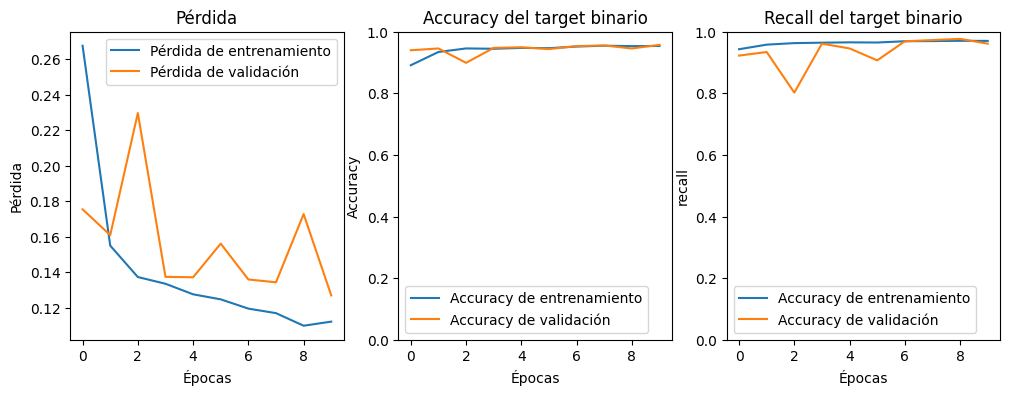

In [ ]:
history=pd.read_csv(main_dir + "model_training/" + "history_01_00_mobilnet.csv")
plot_learning_curves(history, type_g=1)

### Resnet

In [ ]:
model_resnet_base = create_backbone_classification_model_v2(backbone='ResNet50')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
train_model(model_resnet_base,
            train_generator, val_generator, 10, 0.001, "01_00_ResNet50", [early_stopping, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


148/148 ━━━━━━━━━━━━━━━━━━━━ 1865s 12s/step - accuracy: 0.7385 - auroc: 0.5195 - loss: 0.5681 - precision: 0.7554 - recall: 0.9590 - val_accuracy: 0.5010 - val_auroc: 0.8941 - val_loss: 0.7755 - val_precision: 0.5010 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 792ms/step - accuracy: 0.7630 - auroc: 0.7783 - loss: 0.4958 - precision: 0.7647 - recall: 0.9963 - val_accuracy: 0.5010 - val_auroc: 0.8991 - val_loss: 0.7395 - val_precision: 0.5010 - val_recall: 0.9845 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 131s 855ms/step - accuracy: 0.7787 - auroc: 0.8194 - loss: 0.4462 - precision: 0.7895 - recall: 0.9725 - val_accuracy: 0.5126 - val_auroc: 0.9034 - val_loss: 0.7787 - val_precision: 0.5070 - val_recall: 0.9806 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 131s 781ms/step - accuracy: 0.7974 - auroc: 0.8475 - loss: 0.4099 - precision: 0.8173 - recall: 0.9516 - val_accuracy: 0.5883 - val_auroc: 0.9089 - va

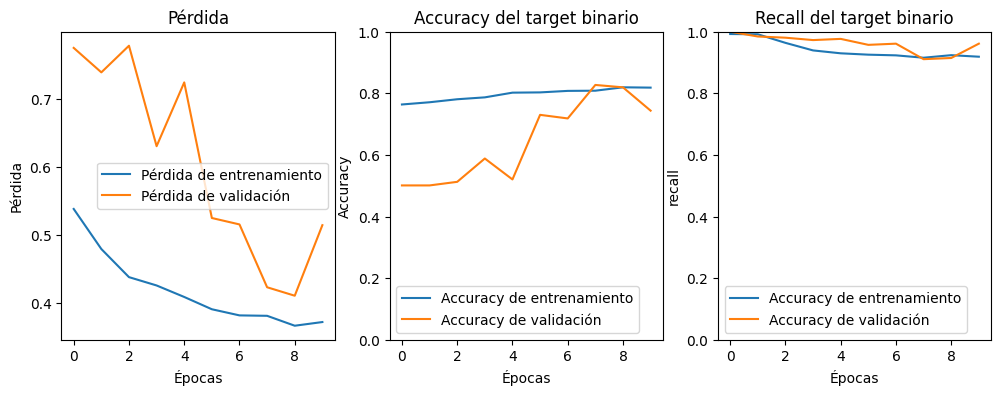

In [ ]:
history=pd.read_csv(main_dir + "model_training/" + "history_01_00_ResNet50.csv")
plot_learning_curves(history, type_g=1)

### DenseNet

In [ ]:
model_densnet_base = create_backbone_classification_model_v2(backbone='DenseNet121')
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_model(model_densnet_base,
            train_generator, val_generator, 10, 0.001, "01_00_DenseNet121", [early_stopping, reduce_lr])

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8619 - auroc: 0.9008 - loss: 0.3091 - precision_3: 0.8845 - recall_3: 0.9452 - val_accuracy: 0.9320 - val_auroc: 0.9853 - val_loss: 0.1672 - val_precision_3: 0.9407 - val_recall_3: 0.9225 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 827ms/step - accuracy: 0.9194 - auroc: 0.9659 - loss: 0.1944 - precision_3: 0.9411 - recall_3: 0.9560 - val_accuracy: 0.9417 - val_auroc: 0.9882 - val_loss: 0.1436 - val_precision_3: 0.9419 - val_recall_3: 0.9419 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 127s 824ms/step - accuracy: 0.9321 - auroc: 0.9773 - loss: 0.1582 - precision_3: 0.9593 - recall_3: 0.9520 - val_accuracy: 0.9495 - val_auroc: 0.9891 - val_loss: 0.1407 - val_precision_3: 0.9677 - val_recall_3: 0.9302 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 825ms/step - accuracy: 0.9382 - auroc: 0.9788 - loss: 0.1542 - precision_3: 0.9605 - recall_3: 0.9592 - val_accu

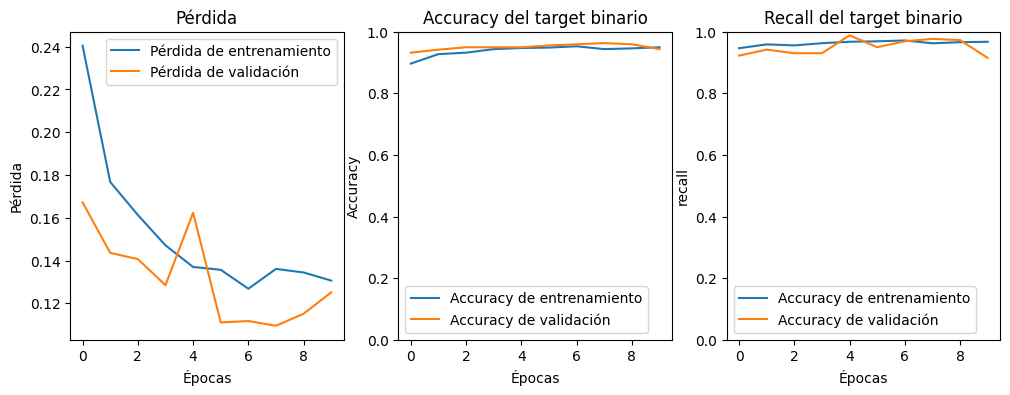

In [ ]:
history=pd.read_csv(main_dir + "model_training/" + "history_01_00_DenseNet121.csv")
plot_learning_curves(history, type_g=1)

### Inception

In [ ]:
model_inception_base = create_backbone_classification_model_v2(backbone='InceptionV3')
#model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_model(model_inception_base,
            train_generator, val_generator, 10, 0.001, "01_00_InceptionV3", [early_stopping, reduce_lr])

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8417 - auroc: 0.8733 - loss: 0.3627 - precision_4: 0.8820 - recall_4: 0.9130 - val_accuracy: 0.9068 - val_auroc: 0.9788 - val_loss: 0.2298 - val_precision_4: 0.8723 - val_recall_4: 0.9535 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 130s 843ms/step - accuracy: 0.9153 - auroc: 0.9630 - loss: 0.2057 - precision_4: 0.9382 - recall_4: 0.9515 - val_accuracy: 0.9301 - val_auroc: 0.9849 - val_loss: 0.1814 - val_precision_4: 0.9022 - val_recall_4: 0.9651 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 121s 785ms/step - accuracy: 0.9169 - auroc: 0.9659 - loss: 0.1994 - precision_4: 0.9406 - recall_4: 0.9510 - val_accuracy: 0.8796 - val_auroc: 0.9801 - val_loss: 0.2724 - val_precision_4: 0.8203 - val_recall_4: 0.9729 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 120s 781ms/step - accuracy: 0.9245 - auroc: 0.9740 - loss: 0.1762 - precision_4: 0.9486 - recall_4: 0.9537 - val_accu

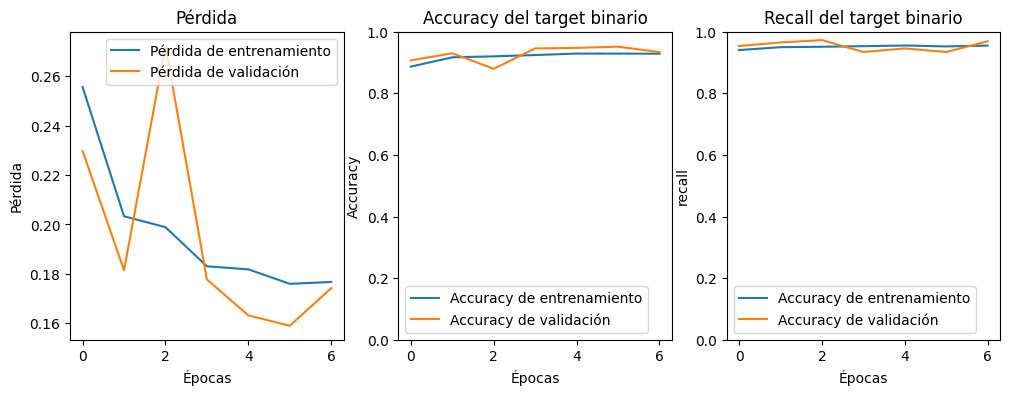

In [ ]:
history=pd.read_csv(main_dir + "model_training/" + "history_01_00_InceptionV3.csv")
plot_learning_curves(history, type_g=1)

### VGG16

In [ ]:
model_vgg_base = create_backbone_classification_model_v2(backbone='VGG16')
#model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_model(model_vgg_base,
            train_generator, val_generator, 10, 0.001, "01_00_VGG16", [early_stopping, reduce_lr])

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 151s 867ms/step - accuracy: 0.7824 - auroc: 0.7370 - loss: 0.4780 - precision_5: 0.7830 - recall_5: 0.9945 - val_accuracy: 0.9010 - val_auroc: 0.9513 - val_loss: 0.3550 - val_precision_5: 0.8935 - val_recall_5: 0.9109 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 120s 780ms/step - accuracy: 0.8787 - auroc: 0.9434 - loss: 0.2758 - precision_5: 0.9034 - recall_5: 0.9423 - val_accuracy: 0.8990 - val_auroc: 0.9594 - val_loss: 0.2729 - val_precision_5: 0.9120 - val_recall_5: 0.8837 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 794ms/step - accuracy: 0.9047 - auroc: 0.9575 - loss: 0.2246 - precision_5: 0.9287 - recall_5: 0.9507 - val_accuracy: 0.9165 - val_auroc: 0.9649 - val_loss: 0.2468 - val_precision_5: 0.9057 - val_recall_5: 0.9302 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 804ms/step - accuracy: 0.9052 - auroc: 0.9568 - loss: 0.2273 - precision_5: 0.9271 - recall_5: 0.9500 - val_a

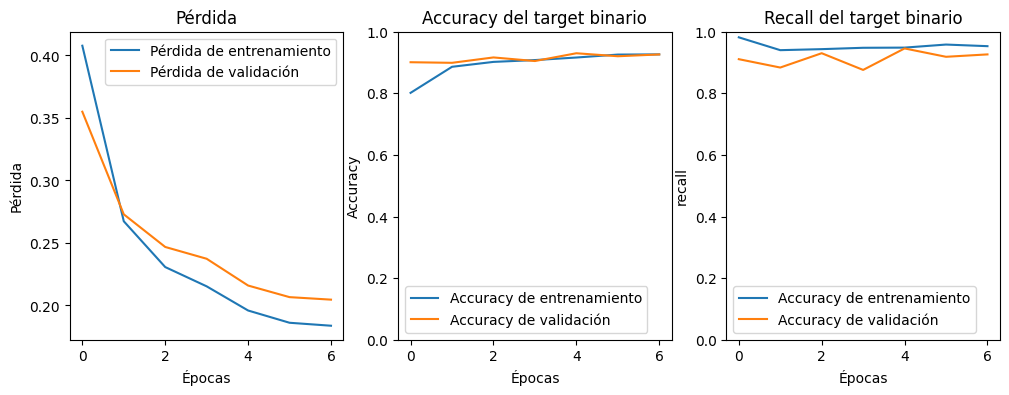

In [ ]:
history=pd.read_csv(main_dir + "model_training/" + "history_01_00_VGG16.csv")
plot_learning_curves(history, type_g=1)

### Unet

### Comparacion

In [ ]:
lista_history_files=['history_01_00_mobilnet.csv',
                     'history_01_00_ResNet50.csv',
                     "history_01_00_DenseNet121.csv",
                     "history_01_00_InceptionV3.csv",
                     "history_01_00_VGG16.csv"

                     ]

comparar_modelos(lista_history_files)

       Loss  Accuracy  Precision    Recall       AUC  \
0  0.126840  0.957282   0.953846  0.961240  0.988274   
1  0.514253  0.743689   0.670270  0.961240  0.922073   
2  0.125150  0.943689   0.971193  0.914729  0.991509   
3  0.174231  0.933981   0.905797  0.968992  0.989367   
4  0.204626  0.926214   0.926357  0.926357  0.975153   

                           Model  
0     history_01_00_mobilnet.csv  
1     history_01_00_ResNet50.csv  
2  history_01_00_DenseNet121.csv  
3  history_01_00_InceptionV3.csv  
4        history_01_00_VGG16.csv  


## Evaluar U-net en el conjunto de test

Cargar el modelo U-net

In [ ]:
model_dir = dir_mod_RSNA + "model_training/"
model_Unet_v2 = load_model(model_dir + 'model_0_unet_2.keras' )

image_input = model_Unet_v2.input[0]  # Primera entrada (imágenes)
output = model_Unet_v2.output[1]  # Salida del modelo original

# Crear submodelo solo con imágenes
submodel = tf.keras.models.Model(inputs=image_input, outputs=output)

In [ ]:
submodel.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics= [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ],
                       run_eagerly=True)

Reentrenar Unet

In [ ]:
train_model(submodel,
            train_generator, val_generator, 10, 0.001, "01_00_unet_reentrenado", [early_stopping, reduce_lr])

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2153s 13s/step - accuracy: 0.8739 - auroc: 0.9296 - loss: 0.2731 - precision_1: 0.9007 - recall_1: 0.9408 - val_accuracy: 0.9417 - val_auroc: 0.9797 - val_loss: 0.2000 - val_precision_1: 0.9351 - val_recall_1: 0.9496 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9181 - auroc: 0.9652 - loss: 0.2003 - precision_1: 0.9464 - recall_1: 0.9471 - val_accuracy: 0.9553 - val_auroc: 0.9880 - val_loss: 0.1601 - val_precision_1: 0.9368 - val_recall_1: 0.9767 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 193s 969ms/step - accuracy: 0.9280 - auroc: 0.9719 - loss: 0.1749 - precision_1: 0.9538 - recall_1: 0.9527 - val_accuracy: 0.9320 - val_auroc: 0.9882 - val_loss: 0.1704 - val_precision_1: 0.9705 - val_recall_1: 0.8915 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 146s 956ms/step - accuracy: 0.9352 - auroc: 0.9739 - loss: 0.1699 - precision_1: 0.9554 - recall_1: 0.9605 - val_accur

Unet - evaluar solo parte de classificacion

In [ ]:
submodel.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9082 - auroc: 0.6498 - loss: 0.3162 - precision_1: 0.5398 - recall_1: 0.6577


[0.21710780262947083,
 0.9358974099159241,
 0.9186602830886841,
 0.9846153855323792,
 0.971515417098999]